In [ ]:
'''
Text embedding with BERT model which is transformer based lang model
-- BERT model was downloaded from TensorFlow hub: bert_preprocess and bert_model
-- GPT model for Text Embedding  
'''

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report
from transformers import GPT2Tokenizer, GPT2Model
import torch

In [3]:
#BERT model from TensorFlow hub
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
bert_preprocess_model = hub.KerasLayer(preprocess_url)
bert_model = hub.KerasLayer(encoder_url)

In [31]:
text_test = ['I am in the library','I get sick']
bert_preprocess_result=bert_preprocess_model(text_test)
bert_preprocess_result.keys()

dict_keys(['input_type_ids', 'input_mask', 'input_word_ids'])

In [32]:
bert_preprocess_result['input_word_ids'] # I get sick represents as: CLS I get sick SEP

<tf.Tensor: shape=(2, 128), dtype=int32, numpy=
array([[ 101, 1045, 2572, 1999, 1996, 3075,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 101, 1045, 2131, 5305,  102,    0,    0,    0,    0,    0,    0,
           0,

In [34]:
bert_model_result=bert_model(bert_preprocess_result)
bert_model_result.keys()

dict_keys(['pooled_output', 'sequence_output', 'encoder_outputs', 'default'])

In [39]:
bert_model_result['encoder_outputs'][-1]==bert_model_result['sequence_output']

<tf.Tensor: shape=(2, 128, 768), dtype=bool, numpy=
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])>

In [40]:
bert_model_result['pooled_output']

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8810733 , -0.30647543, -0.3067159 , ...,  0.34875298,
        -0.6965154 ,  0.945937  ],
       [-0.9031191 , -0.37948215,  0.10816693, ...,  0.12191948,
        -0.71289766,  0.95354706]], dtype=float32)>

# Text Classification using BERT model

In [3]:
## Spam email data set was taken from: https://www.kaggle.com/datasets/mfaisalqureshi/spam-email?resource=download
df=pd.read_csv('spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df['Category'].value_counts()
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_spam=df[df.spam==1]
df_ham=df[df.spam==0]
df_ham_blance=df_ham.sample(df_spam.shape[0])
df_blance=pd.concat([df_spam,df_ham_blance])
df_blance['spam'].value_counts()
x_train, x_test, y_train, y_text= train_test_split(df_blance.Message,df_blance.spam, stratify=df_blance['spam'])

In [12]:
input_text=tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocess_text=bert_preprocess_model(input_text)
output_text=bert_model(preprocess_text)

layer=tf.keras.layers.Dropout(0.1,name="dropout")(output_text['pooled_output'])
dense=tf.keras.layers.Dense(1, activation='sigmoid',name="dense")(layer)

model=tf.keras.Model(inputs=[input_text],outputs=[dense])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [13]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [14]:
model.fit(x_train,y_train, epochs=3)

Epoch 1/3
35/35 [==============================] - 187s 5s/step - loss: 0.6064 - accuracy: 0.7295 - precision: 0.7299 - recall: 0.7286
Epoch 2/3
35/35 [==============================] - 175s 5s/step - loss: 0.4886 - accuracy: 0.8259 - precision: 0.8219 - recall: 0.8321
Epoch 3/3
35/35 [==============================] - 176s 5s/step - loss: 0.4145 - accuracy: 0.8705 - precision: 0.8535 - recall: 0.8946


In [15]:
model.evaluate(x_test, y_text)

12/12 [==============================] - 63s 5s/step - loss: 0.3897 - accuracy: 0.8636 - precision: 0.8238 - recall: 0.9251


[0.38970690965652466,
 0.8636363744735718,
 0.8238095045089722,
 0.9251337051391602]

In [21]:
y_pred=model.predict(x_test)
y_pred=y_pred.flatten()

12/12 [==============================] - 61s 5s/step


In [23]:
y_pred=[(lambda x:1 if x>0.5 else 0)(i) for i in y_pred]

Text(50.722222222222214, 0.5, 'Truth')

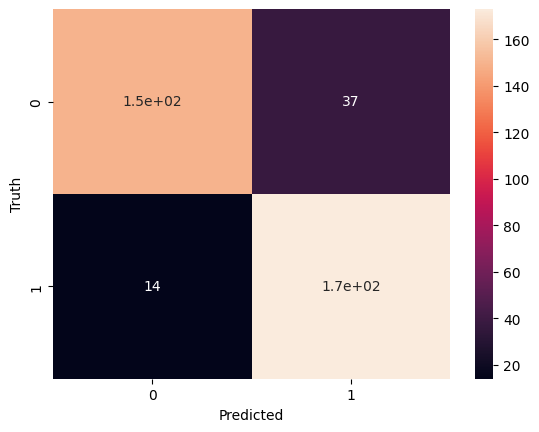

In [36]:
cm=confusion_matrix(y_text, y_pred)
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [37]:
print(classification_report(y_text, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85       187
           1       0.82      0.93      0.87       187

    accuracy                           0.86       374
   macro avg       0.87      0.86      0.86       374
weighted avg       0.87      0.86      0.86       374



In [40]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
reviews_pred=model.predict(reviews)

1/1 [==============================] - 1s 1s/step


In [41]:
reviews_pred=[(lambda x:1 if x>0.5 else 0)(i) for i in reviews_pred]

In [42]:
reviews_pred

[1, 1, 1, 0, 0]

# Text Embedding using GPT model

In [ ]:
# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")

# Example text to convert to word embeddings
text_to_embed = "Your input text goes here."

# Tokenize the text
tokens = tokenizer(text_to_embed, return_tensors="pt")

# Forward pass through the model to obtain embeddings
outputs = model(**tokens)

# Extract the embeddings from the last layer
last_hidden_states = outputs.last_hidden_state

# Take the mean of embeddings to obtain a single vector for the entire text
mean_embeddings = torch.mean(last_hidden_states, dim=1).squeeze()

# Print the resulting embedding vector
print("Word Embedding Vector:", mean_embeddings)


In [ ]:
mean_embeddings.tolist()